# Data visualization

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import re
import os
from sqlalchemy import create_engine, text
from dotenv import load_dotenv


# Load .env file
load_dotenv(override=True)

# Envorioment variable
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

# Create connection
URL = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(URL)

conn = engine.connect()

try:
    print("Connection Succesfull!!" if conn else "")
    conn.close()

except Exception as e:
    print("Error al conectar la base datos en", e)

Connection Succesfull!!


# Connection with Data Base PgSql
1. Create connection
2. Show tables
3. Verificate if tables are fill

In [2]:
# 
with engine.connect() as conn:
    # Setting schema
    conn.execute(text("SET search_path TO riwi_ventas"))
    
    # Get table list
    table_list = pd.read_sql(text("SELECT table_name FROM information_schema.tables WHERE table_schema = 'riwi_ventas';"),conn)
    
    msg = f"| Tablas encontradas: {len(table_list)} |"
    print("-"*len(msg))
    print(msg)
    print("-"*len(msg))
    idx = 0
    for table in table_list["table_name"]:
        idx+=1
        print(f"{idx}. {table}")
        
    print("\n-------------------------------------------\n")

    # List existing and filled tables.
    for table in table_list["table_name"]:
        verfy = pd.read_sql(text(f"select * from {table} LIMIT 1000;"),conn)
        if not verfy.empty:
            print(f"Table: {table} exist and is filled")
        else:
            print(f"Table: | {table} | doesn't exist or is empty please check in the Data base.")

    conn.close()

-------------------------
| Tablas encontradas: 6 |
-------------------------
1. tipo_producto
2. producto
3. ciudad
4. factura_ventas
5. tipo_venta
6. tipo_cliente

-------------------------------------------

Table: tipo_producto exist and is filled
Table: producto exist and is filled
Table: ciudad exist and is filled
Table: factura_ventas exist and is filled
Table: tipo_venta exist and is filled
Table: tipo_cliente exist and is filled


## Load an prepare Data

In [3]:
with engine.connect() as conn:
    conn.execute(text("SET search_path TO riwi_ventas"))
    
    # Query to call the table ventas
    
    df_sales = pd.read_sql("SELECT * from factura_ventas;", conn)
    
    list_cols = df_sales.columns.tolist()

    print(f"Data loaded: {len(df_sales):,} sales records")
    print("Aviable columns")
    for tables in list_cols:
        print(df_sales[tables].name,end= ", ")
    print(" ")
    print("\nFirst 5 rows:")
    print(df_sales.head())

Data loaded: 1,047,429 sales records
Aviable columns
venta_id, fecha, ciudad_id, producto_id, tipo_venta_id, tipo_cliente_id, cantidad, precio_unitario, descuento, costo_envio, total_venta,  

First 5 rows:
   venta_id       fecha  ciudad_id  producto_id  tipo_venta_id  \
0      1575  2025-10-20         18           42              3   
1      1576  2025-11-01         19           39              2   
2      1577  2025-11-14         11           44              2   
3      1578  2025-10-31          2           58              1   
4      1579  2025-11-10         28           51              4   

   tipo_cliente_id  cantidad  precio_unitario  descuento  costo_envio  \
0                3       2.0           4552.0       0.10          0.0   
1                1       9.0           3780.0       0.05          0.0   
2                1       9.0           4309.0       0.05          0.0   
3                4       5.0           1483.0       0.00          0.0   
4                1       2.0   

## Data cleaning and transformation

In [4]:
# Parse fecha to datetime format
df_sales['fecha'] = pd.to_datetime(df_sales['fecha'])

# Obtain Month and Year
df_sales['ano'] = df_sales['fecha'].dt.year
df_sales['month'] = df_sales['fecha'].dt.month
df_sales['dia_semana'] = df_sales['fecha'].dt.day_name()

# Calculate Month-Year for agrupations
df_sales['year_month'] = df_sales['fecha'].dt.to_period('M')

# Check Data
print("\nInformation about DF")
print(df_sales.info())
print(f"\nDate range: {df_sales['fecha'].min()} a {df_sales['fecha'].max()}")
print(f"Current Year: {sorted(df_sales['ano'].unique())}")


Information about DF
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1047429 entries, 0 to 1047428
Data columns (total 15 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   venta_id         1047429 non-null  int64         
 1   fecha            1047429 non-null  datetime64[ns]
 2   ciudad_id        1047429 non-null  int64         
 3   producto_id      1047429 non-null  int64         
 4   tipo_venta_id    1047429 non-null  int64         
 5   tipo_cliente_id  1047429 non-null  int64         
 6   cantidad         1047429 non-null  float64       
 7   precio_unitario  1047429 non-null  float64       
 8   descuento        1047429 non-null  float64       
 9   costo_envio      1047429 non-null  float64       
 10  total_venta      1047429 non-null  float64       
 11  ano              1047429 non-null  int32         
 12  month            1047429 non-null  int32         
 13  dia_semana       1047429 non-null  

### DESCRIPTIVE METRICS

In [5]:
print("\n" + "="*20)
print("DESCRIPTIVE METRICS")
print("="*20)

# Create a summary table
metrics_data = {
    'Metric': [
        'Total Sales Amount',
        'Average Transaction Value',
        'Median Transaction Value',
        'Standard Deviation',
        'Minimum Transaction',
        'Maximum Transaction',
        'Total Quantity Sold',
        'Average Quantity per Transaction',
        'Average Unit Price',
        'Average Discount',
        'Average Shipping Cost'
    ],
    'Value': [
        f"${df_sales['total_venta'].sum():,.2f}",
        f"${df_sales['total_venta'].mean():,.2f}",
        f"${df_sales['total_venta'].median():,.2f}",
        f"${df_sales['total_venta'].std():,.2f}",
        f"${df_sales['total_venta'].min():,.2f}",
        f"${df_sales['total_venta'].max():,.2f}",
        f"{df_sales['cantidad'].sum():,.0f} units",
        f"{df_sales['cantidad'].mean():.2f} units",
        f"${df_sales['precio_unitario'].mean():,.2f}",
        f"${df_sales['descuento'].mean():,.2f}",
        f"${df_sales['costo_envio'].mean():,.2f}"
    ]
}

metrics_df = pd.DataFrame(metrics_data)
print("\nKey Sales Metrics:")
print(metrics_df.to_string(index=False))


DESCRIPTIVE METRICS

Key Sales Metrics:
                          Metric              Value
              Total Sales Amount $19,048,014,335.40
       Average Transaction Value         $18,185.49
        Median Transaction Value         $15,393.80
              Standard Deviation         $37,771.09
             Minimum Transaction              $0.00
             Maximum Transaction     $18,249,975.00
             Total Quantity Sold    5,912,148 units
Average Quantity per Transaction         5.64 units
              Average Unit Price          $3,076.07
                Average Discount              $0.10
           Average Shipping Cost          $2,561.15


### VISUALIZATION 1: MONTHLY SALES DISTRIBUTION

VISUALIZATION 1: MONTHLY SALES DISTRIBUTION

Monthly sales calculadas: 2 meses
   mes_ano   total_venta   cantidad  transactions
0  2025-10  7.634607e+09  2367719.0        419189
1  2025-11  1.141341e+10  3544429.0        628240


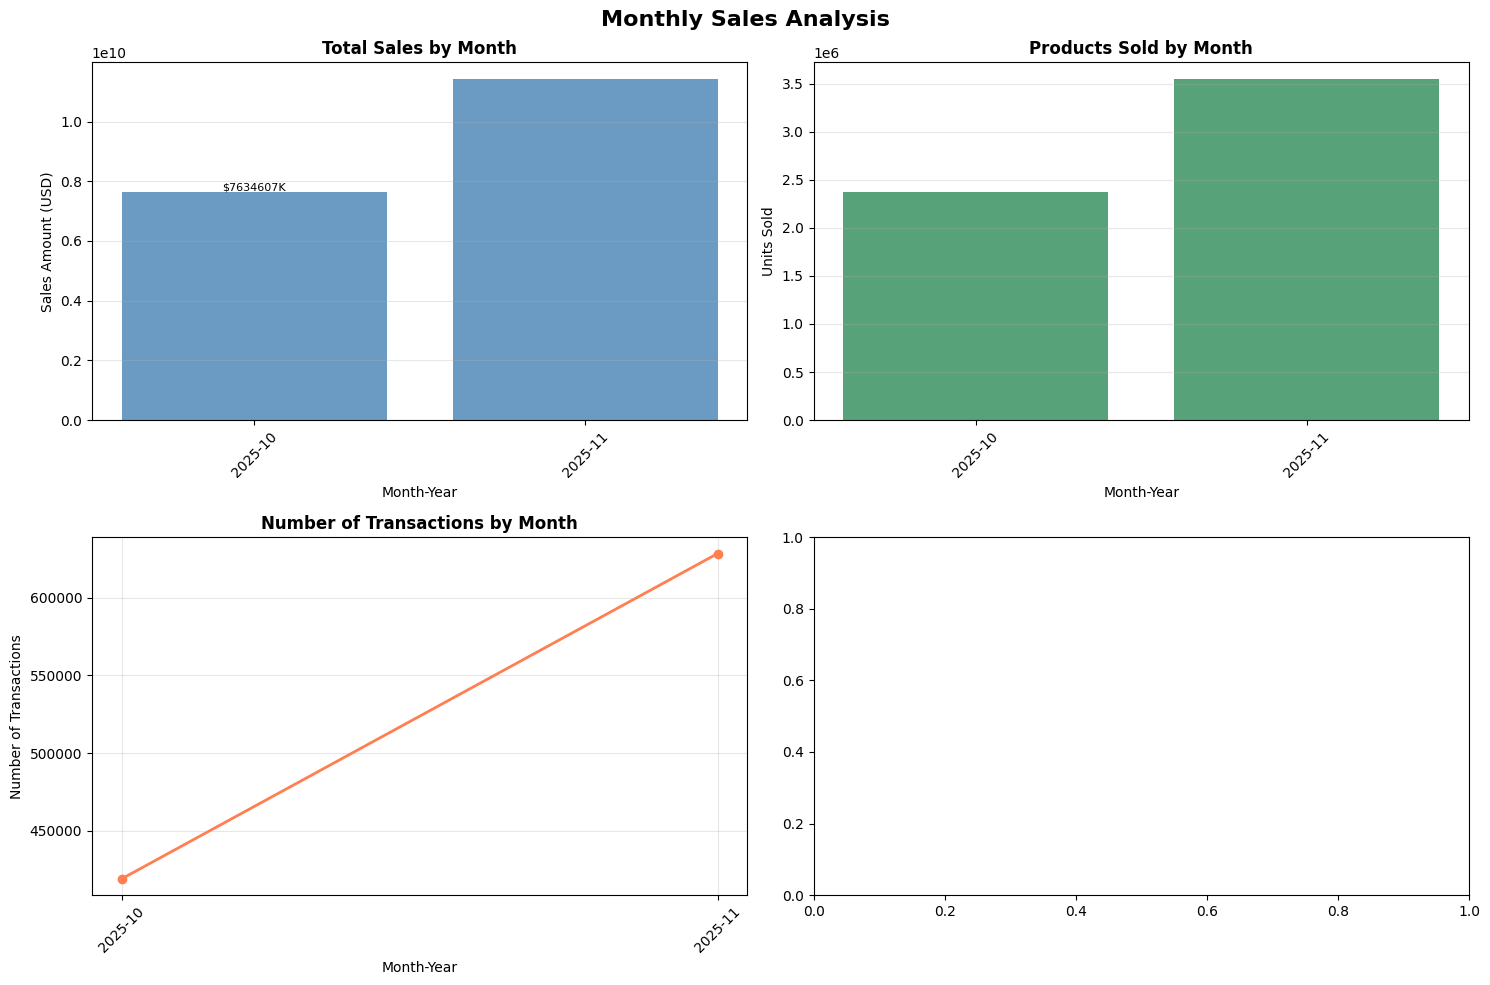

In [19]:
print("VISUALIZATION 1: MONTHLY SALES DISTRIBUTION")

# Primero, asegurémonos de que tenemos la columna mes_ano
# Si no existe, créala
if 'mes_ano' not in df_sales.columns:
    print("Creando columna 'mes_ano'...")
    df_sales['mes_ano'] = df_sales['fecha'].dt.to_period('M')

# Ahora calculamos las ventas mensuales
monthly_sales = df_sales.groupby('mes_ano').agg({
    'total_venta': 'sum',
    'cantidad': 'sum',
    'venta_id': 'count'
}).rename(columns={'venta_id': 'transactions'}).reset_index()

print(f"\nMonthly sales calculadas: {len(monthly_sales)} meses")
print(monthly_sales.head())

monthly_sales['year_month_str'] = monthly_sales['mes_ano'].astype(str)

# Create the visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Monthly Sales Analysis', fontsize=16, fontweight='bold')

# Chart 1: Total sales by month
axes[0, 0].bar(monthly_sales['year_month_str'], monthly_sales['total_venta'], 
               color='steelblue', alpha=0.8)
axes[0, 0].set_title('Total Sales by Month', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Month-Year')
axes[0, 0].set_ylabel('Sales Amount (USD)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Add value labels on top of bars
for i, v in enumerate(monthly_sales['total_venta']):
    if i % 3 == 0:  # Show every 3rd value to avoid clutter
        axes[0, 0].text(i, v, f'${v/1000:.0f}K', 
                       ha='center', va='bottom', fontsize=8)

# Chart 2: Quantity sold by month
axes[0, 1].bar(monthly_sales['year_month_str'], monthly_sales['cantidad'], 
               color='seagreen', alpha=0.8)
axes[0, 1].set_title('Products Sold by Month', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Month-Year')
axes[0, 1].set_ylabel('Units Sold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Chart 3: Number of transactions by month
axes[1, 0].plot(monthly_sales['year_month_str'], monthly_sales['transactions'], 
                marker='o', linewidth=2, color='coral')
axes[1, 0].set_title('Number of Transactions by Month', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Month-Year')
axes[1, 0].set_ylabel('Number of Transactions')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)



plt.tight_layout()
plt.show()

### TOP 5 BEST-SELLING PRODUCTS


Running analysis query...

QUERY RESULTS:
--------------------

1. cereal
   Units: 500,859.0
   Revenue: $1,601,950,580.55
   Transactions: 87,386
   Avg/Transaction: 5.7 units

2. cafe
   Units: 496,524.0
   Revenue: $1,590,710,754.50
   Transactions: 87,536
   Avg/Transaction: 5.7 units

3. leche
   Units: 494,968.0
   Revenue: $1,608,015,299.50
   Transactions: 87,485
   Avg/Transaction: 5.7 units

4. mantequilla
   Units: 494,074.0
   Revenue: $1,588,934,043.05
   Transactions: 87,328
   Avg/Transaction: 5.7 units

5. chocolate
   Units: 492,798.0
   Revenue: $1,591,025,650.55
   Transactions: 87,408
   Avg/Transaction: 5.6 units


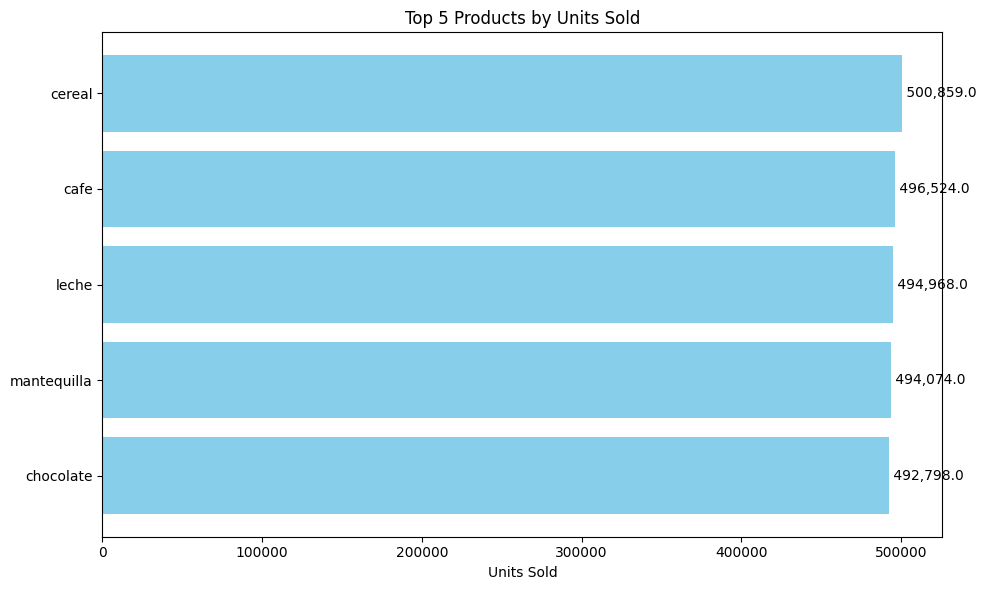

In [ ]:

with engine.connect() as conn:
    conn.execute(text("SET search_path TO riwi_ventas"))
    
    query = text("""
        SELECT 
            p.nombre_producto,
            SUM(fv.cantidad) as total_units,
            SUM(fv.total_venta) as total_revenue,
            COUNT(fv.venta_id) as transactions
        FROM factura_ventas fv
        JOIN producto p ON fv.producto_id = p.producto_id
        GROUP BY p.nombre_producto
        ORDER BY SUM(fv.cantidad) DESC
        LIMIT 5
    """)
    
    top_products = pd.read_sql(query, conn)
    
print("\nQUERY RESULTS:")
print("-" * 20)

for i, row in top_products.iterrows():
    print(f"\n{i+1}. {row['nombre_producto']}")
    print(f"   Units: {row['total_units']:,}")
    print(f"   Revenue: ${row['total_revenue']:,.2f}")
    print(f"   Transactions: {row['transactions']:,}")
    print(f"   Avg/Transaction: {row['total_units']/row['transactions']:.1f} units")

# Simple bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_products['nombre_producto'], top_products['total_units'], color='skyblue')
plt.xlabel('Units Sold')
plt.title('Top 5 Products by Units Sold')
plt.gca().invert_yaxis()  # Highest on top

# Add values
for i, v in enumerate(top_products['total_units']):
    plt.text(v, i, f' {v:,}', va='center')

plt.tight_layout()
plt.show()

###  CURRENT YEAR VS PREVIOUS YEAR

YEARLY SALES ANALYSIS

Yearly Sales Data:
     year   total_sales  total_units  transactions
0  2025.0  1.904801e+10    5912148.0       1047429

Years in database: 1
ANALYSIS FOR YEAR 2025

📊 PERFORMANCE FOR 2025:
   Total Sales: $19,048,014,335.40
   Units Sold: 5,912,148.0
   Transactions: 1,047,429.0
   Average Sale: $18,185.49
   Units per Transaction: 5.6


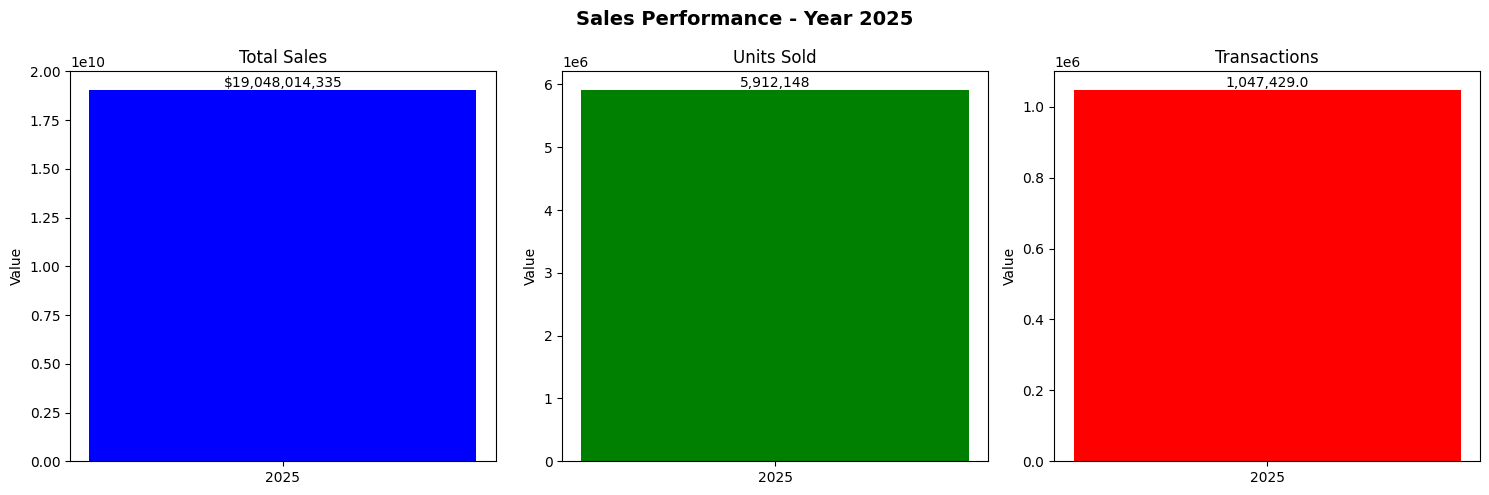

MONTHLY ANALYSIS FOR 2025

Monthly Performance for 2025:


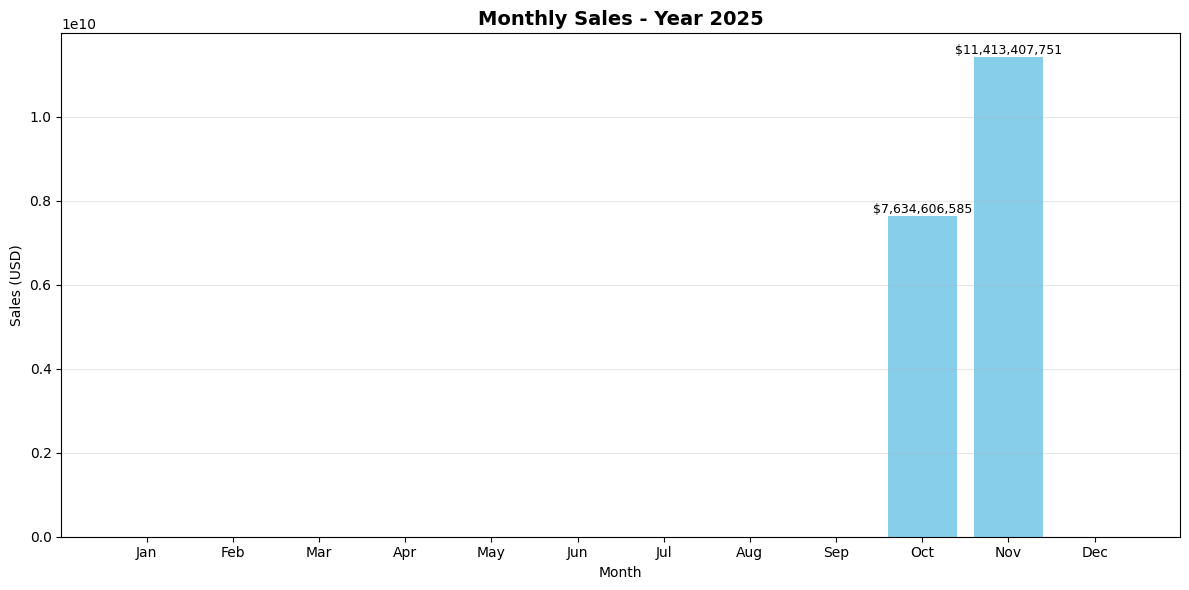


📈 BEST MONTH: Nov
   Sales: $11,413,407,750.70
   Units: 3,544,429.0

📉 WORST MONTH: Jan
   Sales: $0.00
   Units: 0.0
ANALYSIS COMPLETE


In [25]:

print("YEARLY SALES ANALYSIS")


with engine.connect() as conn:
    conn.execute(text("SET search_path TO riwi_ventas"))
    
    # Query para obtener ventas por año
    query = text("""
        SELECT 
            EXTRACT(YEAR FROM fecha) as year,
            SUM(total_venta) as total_sales,
            SUM(cantidad) as total_units,
            COUNT(*) as transactions
        FROM factura_ventas
        WHERE fecha IS NOT NULL
        GROUP BY EXTRACT(YEAR FROM fecha)
        ORDER BY year
    """)
    
    yearly_data = pd.read_sql(query, conn)

print("\nYearly Sales Data:")
print(yearly_data)

# Verificar cuántos años hay
num_years = len(yearly_data)
print(f"\nYears in database: {num_years}")

if num_years == 1:

    single_year = yearly_data.iloc[0]
    year = int(single_year['year'])
    
    print(f"ANALYSIS FOR YEAR {year}")

    
    print(f"\n📊 PERFORMANCE FOR {year}:")
    print(f"   Total Sales: ${single_year['total_sales']:,.2f}")
    print(f"   Units Sold: {single_year['total_units']:,}")
    print(f"   Transactions: {single_year['transactions']:,}")
    print(f"   Average Sale: ${single_year['total_sales']/single_year['transactions']:,.2f}")
    print(f"   Units per Transaction: {single_year['total_units']/single_year['transactions']:.1f}")
    
    # Gráfico simple para 1 año
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Datos para mostrar
    metrics = ['Total Sales', 'Units Sold', 'Transactions']
    values = [
        single_year['total_sales'],
        single_year['total_units'], 
        single_year['transactions']
    ]
    colors = ['blue', 'green', 'red']
    
    for i, (metric, value, color) in enumerate(zip(metrics, values, colors)):
        axes[i].bar([str(year)], [value], color=color)
        axes[i].set_title(metric)
        axes[i].set_ylabel('Value')
        
        # Formatear los valores en las barras
        if metric == 'Total Sales':
            axes[i].text(0, value, f'${value:,.0f}', ha='center', va='bottom')
        elif metric == 'Units Sold':
            axes[i].text(0, value, f'{value:,.0f}', ha='center', va='bottom')
        else:
            axes[i].text(0, value, f'{value:,}', ha='center', va='bottom')
    
    plt.suptitle(f'Sales Performance - Year {year}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"MONTHLY ANALYSIS FOR {year}")

    
    with engine.connect() as conn:
        conn.execute(text("SET search_path TO riwi_ventas"))
        
        # Query para obtener ventas por mes del año actual
        monthly_query = text(f"""
            SELECT 
                EXTRACT(MONTH FROM fecha) as month,
                SUM(total_venta) as monthly_sales,
                SUM(cantidad) as monthly_units,
                COUNT(*) as monthly_transactions
            FROM factura_ventas
            WHERE EXTRACT(YEAR FROM fecha) = {year}
            GROUP BY EXTRACT(MONTH FROM fecha)
            ORDER BY month
        """)
        
        monthly_data = pd.read_sql(monthly_query, conn)
    
    if not monthly_data.empty:
        print(f"\nMonthly Performance for {year}:")
        
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        
        # Crear DataFrame completo con todos los meses
        all_months = pd.DataFrame({'month': range(1, 13)})
        monthly_data = pd.merge(all_months, monthly_data, on='month', how='left')
        monthly_data = monthly_data.fillna(0)
        
        # Gráfico de ventas mensuales
        plt.figure(figsize=(12, 6))
        
        bars = plt.bar(month_names, monthly_data['monthly_sales'], color='skyblue')
        plt.title(f'Monthly Sales - Year {year}', fontsize=14, fontweight='bold')
        plt.xlabel('Month')
        plt.ylabel('Sales (USD)')
        plt.grid(True, alpha=0.3, axis='y')
        
        # Añadir valores en las barras
        for bar, value in zip(bars, monthly_data['monthly_sales']):
            if value > 0:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, height, 
                        f'${value:,.0f}', ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # Mostrar mejor y peor mes
        best_month_idx = monthly_data['monthly_sales'].idxmax()
        worst_month_idx = monthly_data['monthly_sales'].idxmin()
        
        print(f"\n📈 BEST MONTH: {month_names[int(best_month_idx)]}")
        print(f"   Sales: ${monthly_data.loc[best_month_idx, 'monthly_sales']:,.2f}")
        print(f"   Units: {monthly_data.loc[best_month_idx, 'monthly_units']:,}")
        
        print(f"\n📉 WORST MONTH: {month_names[int(worst_month_idx)]}")
        print(f"   Sales: ${monthly_data.loc[worst_month_idx, 'monthly_sales']:,.2f}")
        print(f"   Units: {monthly_data.loc[worst_month_idx, 'monthly_units']:,}")
        
elif num_years >= 2:
    
    current_year_row = yearly_data.iloc[-1]
    previous_year_row = yearly_data.iloc[-2]
    
    current_year = int(current_year_row['year'])
    previous_year = int(previous_year_row['year'])

    print(f"COMPARISON: {current_year} vs {previous_year}")



else:
    print("\nNo yearly data found in database.")

print("ANALYSIS COMPLETE")
